# CIFAR10图像分类
## 总体思路：
采用Resnet作为主干模型对CIFAR10数据集中的图像进行分类，考虑到Kaiming的Resnet的原生输入为224x224,以下实验采用两种方案进行优化。

-**方案1：** 维持CIFAR10中图片的原生大小($32\times32$),将Resnet中的_conv7x7改为:```nn.conv2D(3,64,kernelsize=3, stride=1, padding=1, pad_mode='pad')```,使得$32\times32$的图片能够在resnet中更久得保持相对较大的尺寸，利于特征的提取。

-**方案2：** 采用对pretrained模型进行fine-tune的方法，在数据预处理时，将```resize_op```的操作改为将图片resize至$224\times224$，进行数据增强，同时符合Resnet的原生输入，使得网络能够更好得提取图片中的特征。

#### 参考链接
https://www.mindspore.cn/tutorials/application/zh-CN/r1.7/cv/resnet50.html


#### 模块导入 

In [1]:
import mindspore 
# 载入mindspore的默认数据集 
import mindspore.dataset as ds 
# 常用转化用算子 
import mindspore.dataset.transforms.c_transforms as C 
# 图像转化用算子 
####____#### 
import mindspore.dataset.vision.c_transforms as CV 
from mindspore.common import dtype as mstype 
# mindspore的tensor 
from mindspore import Tensor 
 
 
# 各类网络层都在nn里面 
import mindspore.nn as nn 
import mindspore.ops as ops
from mindspore.nn.optim.momentum import Momentum 
# 参数初始化的方式 
from mindspore.common.initializer import TruncatedNormal 
# 设置mindspore运行的环境 
from mindspore import context 
# 引入训练时候会使用到回调函数，如checkpoint, lossMoniter 
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor 
# 引入模型 
from mindspore.train import Model 
# 引入评估模型的包 
from mindspore.nn.metrics import Accuracy 
 
# numpy 
import numpy as np 
# 画图用 
import matplotlib.pyplot as plt 
 
 
####____#### 
# 下载数据相关的包 
import os
import requests  
import zipfile 

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


##### 数据集下载

In [2]:
!wget https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/ComputerVision/cifar10_mindspore.zip 
!unzip cifar10_mindspore.zip 

--2024-12-24 14:27:10--  https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/ComputerVision/cifar10_mindspore.zip
Resolving ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com (ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com)... 100.125.83.133, 100.125.83.5, 100.125.76.5
Connecting to ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com (ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com)|100.125.83.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170441801 (163M) [application/zip]
Saving to: ‘cifar10_mindspore.zip’

cifar10_mindspore.z 100%[===================>] 162.55M   157MB/s    in 1.0s    

2024-12-24 14:27:11 (157 MB/s) - ‘cifar10_mindspore.zip’ saved [170441801/170441801]

Archive:  cifar10_mindspore.zip
   creating: data/
   creating: data/10-batches-bin/
  inflating: data/10-batches-bin/batches.meta.txt  
  inflating: data/10-b

#### 查看数据集

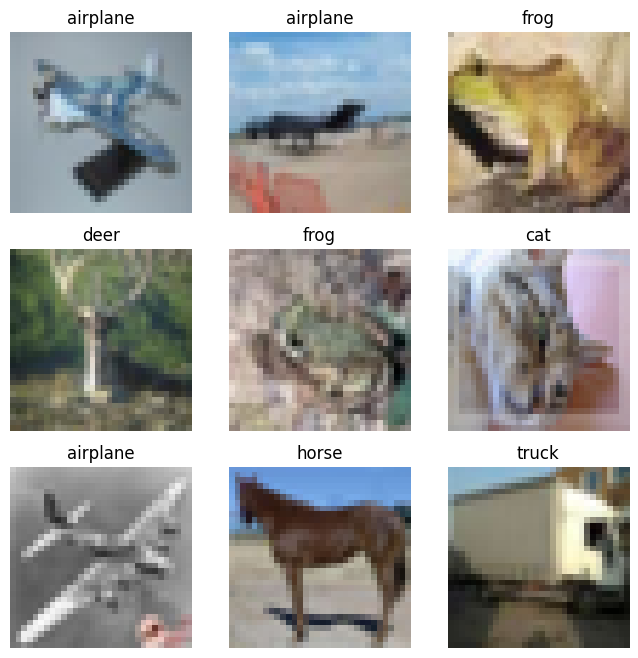

In [2]:
#创建图像标签列表 
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog', 
                 6:'frog',7:'horse',8:'ship',9:'truck'} 
####____#### 
current_path = os.getcwd() 
data_path = os.path.join(current_path, 'data/10-verify-bin') 
cifar_ds = ds.Cifar10Dataset(data_path) 
# 设置图像大小 
plt.figure(figsize=(8,8)) 
i = 1 
# 打印9张子图 
for dic in cifar_ds.create_dict_iterator(): 
    plt.subplot(3,3,i) 
    ####____#### 
    plt.imshow(dic['image'].asnumpy()) 
    plt.xticks([]) 
    plt.yticks([]) 
    plt.axis('off') 
    plt.title(category_dict[dic['label'].asnumpy().sum()]) 
    i +=1 
    if i > 9 : 
        break 
plt.show() 

#### Preprocess

In [3]:
def get_data(datapath): 
    cifar_ds = ds.Cifar10Dataset(datapath) 
    return cifar_ds 
 
def process_dataset(cifar_ds,batch_size =32,status="train", case=None): 
    ''' 
    ---- 定义算子 ---- 
    ''' 
    # 归一化 
    rescale = 1.0 / 255.0 
    # 平移 
    shift = 0.0 
  
    # 使用pretrained或Universal Resnet的resize操作，以对齐Resnet所需的输入尺寸224x224
    # 同时利用插值进行图像增强，mindspore.dataset.vision.c_transformer.Resize默认使用双线性插值
    resize_op = CV.Resize((224,224))
    # Original Size
    if case == 'og':
        resize_op = CV.Resize((32, 32))
    
    rescale_op = CV.Rescale(rescale, shift) 
    # 对于RGB三通道分别设定mean和std 
    normalize_op = CV.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
    if status == "train": 
        # 随机裁剪 
        random_crop_op = CV.RandomCrop([32, 32], [4, 4, 4, 4]) 
        # 随机翻转 
        random_horizontal_op = CV.RandomHorizontalFlip() 
    # 通道变化 
    channel_swap_op = CV.HWC2CHW() 
    # 类型变化 
    typecast_op = C.TypeCast(mstype.int32) 
    ''' 
    ---- 算子运算 ---- 
    ''' 
    cifar_ds = cifar_ds.map(input_columns="label", operations=typecast_op)
    if status == "train": 
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_crop_op) 
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_horizontal_op) 
    cifar_ds = cifar_ds.map(input_columns="image", operations=resize_op) 
    cifar_ds = cifar_ds.map(input_columns="image", operations=rescale_op) 
    cifar_ds = cifar_ds.map(input_columns="image", operations=normalize_op) 
    cifar_ds = cifar_ds.map(input_columns="image", operations=channel_swap_op) 
    # shuffle 
    cifar_ds = cifar_ds.shuffle(buffer_size=1000) 
    # 切分数据集到batch_size 
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True) 
    return cifar_ds 

#### 生成训练集

In [4]:
data_path = os.path.join(current_path, 'data/10-batches-bin') 
batch_size=32
status="train" 
# 生成训练数据集 
cifar_ds = get_data(data_path) 
ds_og_train = process_dataset(cifar_ds,batch_size=batch_size, status=status,case='og') 

### 主模型定义
采用ResNet，存在两种实现，第一种使用Mindspore，第二种为了进行finetune而采用Mindvision进行实现，其中留有resnet101或更高层次接口，经过验证发现，其需10h以上时间进行训练，且测试集准确度无显著提升，故仅选用**resnet50**

##### Resnet Mindspore

In [5]:
"""ResNet.""" 
def _weight_variable(shape, factor=0.01): 
    init_value = np.random.randn(*shape).astype(np.float32) * factor 
    return Tensor(init_value) 
 
 
def _conv3x3(in_channel, out_channel, stride=1): 
    weight_shape = (out_channel, in_channel, 3, 3) 
    weight = _weight_variable(weight_shape) 
    return nn.Conv2d(in_channel, out_channel, 
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight) 
 
 
def _conv1x1(in_channel, out_channel, stride=1): 
    weight_shape = (out_channel, in_channel, 1, 1) 
    weight = _weight_variable(weight_shape) 
    return nn.Conv2d(in_channel, out_channel, 
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight) 
 
 
def _conv7x7(in_channel, out_channel, stride=1): 
    weight_shape = (out_channel, in_channel, 7, 7) 
    weight = _weight_variable(weight_shape) 
    return nn.Conv2d(in_channel, out_channel, 
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight) 

def _bn(channel): 
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9, 
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1) 
 
 
def _bn_last(channel): 
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9, 
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1) 
 
 
def _fc(in_channel, out_channel): 
    weight_shape = (out_channel, in_channel) 
    weight = _weight_variable(weight_shape) 
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0) 
 
 
class RBlock(nn.Cell): 
    """ 
    ResNet V1 residual block definition. 
 
    Args: 
        in_channel (int): Input channel. 
        out_channel (int): Output channel. 
        stride (int): Stride size for the first convolutional layer. Default: 1. 
 
    Returns: 
        Tensor, output tensor. 
 
    Examples: 
        >>> RBlock(3, 256, stride=2) 
    """ 
    expansion = 4 
 
    def __init__(self, 
                 in_channel, 
                 out_channel, 
                 stride=1): 
        super(RBlock, self).__init__() 
 
        channel = out_channel // self.expansion 
        self.conv1 = _conv1x1(in_channel, channel, stride=1) 
        self.bn1 = _bn(channel) 
 
        self.conv2 = _conv3x3(channel, channel, stride=stride) 
        self.bn2 = _bn(channel) 
        self.conv3 = _conv1x1(channel, out_channel, stride=1) 
        self.bn3 = _bn_last(out_channel) 
 
        self.relu = nn.ReLU() 
 
        self.down_sample = False 
 
        if stride != 1 or in_channel != out_channel: 
            self.down_sample = True 
        self.down_sample_layer = None 
 
        if self.down_sample: 
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride), 
                                                        _bn(out_channel)]) 
        self.add = ops.Add() 
 
    def construct(self, x): # pylint: disable=missing-docstring 
        identity = x 
 
        out = self.conv1(x) 
        out = self.bn1(out) 
        out = self.relu(out) 
 
        out = self.conv2(out) 
        out = self.bn2(out) 
        out = self.relu(out) 
 
        out = self.conv3(out) 
        out = self.bn3(out) 
 
        if self.down_sample: 
            identity = self.down_sample_layer(identity) 
 
        out = self.add(out, identity) 
        out = self.relu(out) 
 
        return out 
 
 
class Resnet(nn.Cell): 
    """ 
    ResNet architecture. 
 
    Args: 
        block (Cell): Block for network. 
        layer_nums (list): Numbers of block in different layers. 
        in_channels (list): Input channel in each layer. 
        out_channels (list): Output channel in each layer.
        strides (list):  Stride size in each layer. 
        num_classes (int): The number of classes that the training images are belonging to. 
    Returns: 
        Tensor, output tensor. 
 
    Examples: 
        >>> Resnet(RBlock, 
        >>>        [3, 4, 6, 3], 
        >>>        [64, 256, 512, 1024], 
        >>>        [256, 512, 1024, 2048], 
        >>>        [1, 2, 2, 2], 
        >>>        10) 
    """ 
 
    def __init__(self, 
                 block, 
                 layer_nums, 
                 in_channels, 
                 out_channels, 
                 strides, 
                 num_classes): 
        super(Resnet, self).__init__() 
 
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4: 
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!") 
 
        #self.conv1 = _conv7x7(3, 64, stride=2) 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, pad_mode='pad', padding=1)
        self.bn1 = _bn(64) 
        self.relu = ops.ReLU() 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") 
 
        self.layer1 = self._make_layer(block, 
                                       layer_nums[0], 
                                       in_channel=in_channels[0], 
                                       out_channel=out_channels[0], 
                                       stride=strides[0]) 
        self.layer2 = self._make_layer(block, 
                                       layer_nums[1], 
                                       in_channel=in_channels[1], 
                                       out_channel=out_channels[1], 
                                       stride=strides[1]) 
        self.layer3 = self._make_layer(block, 
                                       layer_nums[2], 
                                       in_channel=in_channels[2], 
                                       out_channel=out_channels[2], 
                                       stride=strides[2]) 
        self.layer4 = self._make_layer(block, 
                                       layer_nums[3], 
                                       in_channel=in_channels[3], 
                                       out_channel=out_channels[3], 
                                       stride=strides[3]) 
 
        self.mean = ops.ReduceMean(keep_dims=True) 
        self.flatten = nn.Flatten() 
        self.end_point = _fc(out_channels[3], num_classes) 
 
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride): 
        """ 
        Make stage network of ResNet. 
 
        Args: 
            block (Cell): Resnet block. 
            layer_num (int): Layer number. 
            in_channel (int): Input channel. 
            out_channel (int): Output channel. 
            stride (int): Stride size for the first convolutional layer. 
 
        Returns: 
            SequentialCell, the output layer. 
 
        Examples: 
            >>> _make_layer(RBlock, 3, 128, 256, 2) 
        """ 
        layers = [] 
 
        resnet_block = block(in_channel, out_channel, stride=stride) 
        layers.append(resnet_block) 
 
        for _ in range(1, layer_num): 
            resnet_block = block(out_channel, out_channel, stride=1) 
            layers.append(resnet_block) 
 
        return nn.SequentialCell(layers) 
 
    def construct(self, x): # pylint: disable=missing-docstring 
        x = self.conv1(x) 
        x = self.bn1(x) 
        x = self.relu(x) 
        c1 = self.maxpool(x) 
 
        c2 = self.layer1(c1) 
        c3 = self.layer2(c2) 
        c4 = self.layer3(c3) 
        c5 = self.layer4(c4) 
 
        out = self.mean(c5, (2, 3)) 
        out = self.flatten(out) 
        out = self.end_point(out) 
 
        return out 
 
 
def _resnet50(class_num=10): 
    """ 
    Get ResNet50 neural network. 
 
    Args: 
        class_num (int): Class number. 
 
    Returns: 
        Cell, cell instance of ResNet50 neural network. 
 
    Examples: 
        >>> net = resnet50(10) 
    """ 
    return Resnet(RBlock, 
                  [3, 4, 6, 3], 
                  [64, 256, 512, 1024], 
                  [256, 512, 1024, 2048], 
                  [1, 2, 2, 2], 
                  class_num) 
 
 
def _resnet101(class_num=1001): 
    """ 
    Get ResNet101 neural network. 
 
    Args: 
        class_num (int): Class number. 
 
    Returns: 
        Cell, cell instance of ResNet101 neural network. 
 
    Examples: 
        >>> net = resnet101(1001) 
    """ 
    return Resnet(RBlock, 
                  [3, 4, 23, 3], 
                  [64, 256, 512, 1024], 
                  [256, 512, 1024, 2048], 
                  [1, 2, 2, 2], 
                  class_num) 

def _resnet152(class_num = 10):
    """
    Get ResNet152 neural network. 
 
    Args: 
        class_num (int): Class number. 
 
    Returns: 
        Cell, cell instance of ResNet101 neural network. 
 
    Examples: 
        >>> net = resnet152(10) 
    """
    return Resnet(RBlock,
                  [3, 8, 36, 3], 
                  [64, 256, 512, 1024], 
                  [256, 512, 1024, 2048], 
                  [1, 2, 2, 2],
                  class_num)

##### ResNet2 in Mindspore
采用Mindvision中的classification进行实现

In [6]:
from typing import Type, Union, List, Optional
from mindvision.classification.models.blocks import ConvNormActivation
from mindvision.classification.models.classifiers import BaseClassifier
from mindvision.classification.models.head import DenseHead
from mindvision.classification.models.neck import GlobalAvgPooling
from mindvision.classification.utils.model_urls import model_urls
from mindvision.utils.load_pretrained_model import LoadPretrainedModel

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel,
                                        kernel_size=3, stride=stride, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,
                                        kernel_size=3, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层

        if self.down_sample:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out
    
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel,
                                        kernel_size=1, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,
                                        kernel_size=3, stride=stride, norm=norm)
        self.conv3 = ConvNormActivation(out_channel, out_channel * self.expansion,
                                        kernel_size=1, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.conv3(out)  # 主分支第三层：1*1卷积层

        if self.down_sample:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支

    if stride != 1 or last_out_channel != channel * block.expansion:
        down_sample = ConvNormActivation(last_out_channel, channel * block.expansion,
                                         kernel_size=1, stride=stride, norm=nn.BatchNorm2d, activation=None)

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample, norm=nn.BatchNorm2d))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):
        layers.append(block(in_channel, channel, norm=nn.BatchNorm2d))

    return nn.SequentialCell(layers)

class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], norm: Optional[nn.Cell] = None) -> None:
        super(ResNet, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64 根据CIFAR10图像大小调整卷积核大小为3，使得其保持输入尺寸更久，让模型更好提取特征
        self.conv1 = ConvNormActivation(3, 64, kernel_size=7, stride=2, norm=norm)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)

    def construct(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x


def _resnet(arch: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, input_channel: int):
    backbone = ResNet(block, layers)
    neck = GlobalAvgPooling()  # 平均池化层
    head = DenseHead(input_channel=input_channel, num_classes=num_classes)  # 全连接层
    model = BaseClassifier(backbone, neck, head)  # 将backbone层、neck层和head层连接起来

    if pretrained:
        # 下载并加载预训练模型 224x224输入的pretrain
        LoadPretrainedModel(model, 'https://download.mindspore.cn/vision/classification/resnet50_224.ckpt').run()

    return model


def resnet50(num_classes: int = 10, pretrained: bool = False):
    "ResNet50模型"
    return _resnet("resnet50", ResidualBlock, [3, 4, 6, 3], num_classes, pretrained, 2048)

def resnet101(num_classes: int = 10, pretrained: bool = False):
    "ResNet101模型"
    return _resnet("resnet101", ResidualBlock, [3, 4, 23, 3], num_classes, pretrained, 2048)

def resnet152(num_classes: int = 10, pretrained: bool = False):
    "ResNet152模型"
    return _resnet("resnet152", ResidualBlock, [3, 8, 36, 3], num_classes, pretrained, 2048)

##### Learing Rate
采用Momentum优化器时候所需，用以获取当前学习率

In [6]:
def get_lr(global_step, 
           total_epochs, 
           steps_per_epoch, 
           lr_init=0.01, 
           lr_max=0.1, 
           warmup_epochs=5): 
    """ 
    Generate learning rate array. 
 
    Args: 
        global_step (int): Initial step of training. 
        total_epochs (int): Total epoch of training. 
        steps_per_epoch (float): Steps of one epoch. 
        lr_init (float): Initial learning rate. Default: 0.01. 
        lr_max (float): Maximum learning rate. Default: 0.1. 
        warmup_epochs (int): The number of warming up epochs. Default: 5. 
 
    Returns: 
        np.array, learning rate array. 
    """ 
    lr_each_step = [] 
    total_steps = steps_per_epoch * total_epochs 
    warmup_steps = steps_per_epoch * warmup_epochs 
    if warmup_steps != 0: 
        inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps) 
    else: 
        inc_each_step = 0 
    for i in range(int(total_steps)): 
        if i < warmup_steps: 
            lr = float(lr_init) + inc_each_step * float(i) 
        else: 
            base = ( 1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)) ) 
            lr = float(lr_max) * base * base 
            if lr < 0.0: 
                lr = 0.0 
        lr_each_step.append(lr) 
 
    current_step = global_step 
    lr_each_step = np.array(lr_each_step).astype(np.float32) 
    learning_rate = lr_each_step[current_step:] 
 
    return learning_rate  

##### Loss Function & Optimizer & Network Establishment

In [7]:
# 返回当前设备 
from networkx import NetworkXNoPath
from mindspore.train.loss_scale_manager import FixedLossScaleManager 

device_target = mindspore.context.get_context('device_target') 
# 确定图模型是否下沉到芯片上 
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False 
# 设置模型的设备与图的模式 
context.set_context(mode=context.GRAPH_MODE, device_target=device_target) 
# 初始化模型，non-pretrained
#network = LeNet5_2(10)
network_1 = _resnet50(10)
#network = resnet101(10)

# 使用pretrained进行微调
network = resnet50(1000, pretrained = True)
in_channel = network.head.dense.in_channels
head = DenseHead(input_channel=in_channel, num_classes=10)
# 重置全连接层,使得输出为映射为10
network.head = head


# 使用交叉熵函数作为损失函数 
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean") 


# 优化器和学习率选择
# Adam优化器
#net_opt_1 = nn.Adam(params=network_1.trainable_params(), learning_rate=0.001) 

train_step_size = ds_og_train.get_dataset_size()
#print(train_step_size)
# SGD
lr_1 = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=train_step_size * 100, step_per_epoch=train_step_size, decay_epoch=100)
net_opt_1 = nn.SGD(params=network_1.trainable_params(), learning_rate=lr_1, momentum=0.9, weight_decay=5e-4)

# momentum优化器
#lr = Tensor(get_lr(global_step=0, total_epochs=100, steps_per_epoch=train_step_size)) 
#net_opt = Momentum(network.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=1024) 
#loss_scale = FixedLossScaleManager(1024, False) 

# 监控每个epoch训练的时间 
# time_cb = TimeMonitor(data_size=ds_og_train.get_dataset_size()) 

#### Train and Save path
采用**方案1**的实现，余弦退火学习率+SGD优化器，训练时长约为2.5h

In [ ]:
from mindspore.train.callback import Callback 
 
class EvalCallBack(Callback): 
    def __init__(self, model, eval_dataset, eval_per_epoch, epoch_per_eval): 
        self.model = model 
        self.eval_dataset = eval_dataset 
        self.eval_per_epoch = eval_per_epoch 
        self.epoch_per_eval = epoch_per_eval 
 
    def epoch_end(self, run_context): 
        cb_param = run_context.original_args() 
        cur_epoch = cb_param.cur_epoch_num 
        if cur_epoch % self.eval_per_epoch == 0: 
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False) 
            self.epoch_per_eval["epoch"].append(cur_epoch) 
            self.epoch_per_eval["acc"].append(acc["Accuracy"]) 
            print(acc)

# 设置CheckpointConfig，callback函数。save_checkpoint_steps=训练总数/batch_size 
config_ck = CheckpointConfig(save_checkpoint_steps=1562, 
                             keep_checkpoint_max=5) 
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_resnet_50", directory='./results',config=config_ck) 
# 建立可训练模型 
model_1 = Model(network = network_1, loss_fn=net_loss,optimizer=net_opt_1, metrics={"Accuracy": Accuracy()}) 
eval_per_epoch = 1 
epoch_per_eval = {"epoch": [], "acc": []} 
eval_cb = EvalCallBack(model_1, ds_og_train, eval_per_epoch, epoch_per_eval) 
print("============== Starting Training ==============") 
model_1.train(100, ds_og_train,callbacks=[ckpoint_cb, 
LossMonitor(per_print_times=1),eval_cb],dataset_sink_mode=dataset_sink_mode)

============== Starting Training ==============
epoch: 1 step: 1562, loss is 1.8146519660949707
{'Accuracy': 0.3244238156209987}
epoch: 2 step: 1562, loss is 1.5733001232147217
{'Accuracy': 0.4360595390524968}
epoch: 3 step: 1562, loss is 1.2861486673355103
{'Accuracy': 0.538452304737516}
epoch: 4 step: 1562, loss is 0.8989932537078857
{'Accuracy': 0.599791933418694}
epoch: 5 step: 1562, loss is 0.99267578125
{'Accuracy': 0.6369838348271447}
epoch: 6 step: 1562, loss is 0.9198740720748901
{'Accuracy': 0.6634723111395646}
epoch: 7 step: 1562, loss is 1.207093596458435
{'Accuracy': 0.6926216389244558}
epoch: 8 step: 1562, loss is 1.210342526435852
{'Accuracy': 0.7306538092189501}
epoch: 9 step: 1562, loss is 0.8115222454071045
{'Accuracy': 0.7519206145966709}
epoch: 10 step: 1562, loss is 0.5378831624984741
{'Accuracy': 0.7707066261203586}
epoch: 11 step: 1562, loss is 0.6412001252174377
{'Accuracy': 0.790132842509603}
epoch: 12 step: 1562, loss is 0.7838795781135559
{'Accuracy': 0.80273

##### 方案2训练集

In [9]:
data_path = os.path.join(current_path, 'data/10-batches-bin') 
batch_size=32
status="train" 
# 生成训练数据集 
cifar_ds = get_data(data_path) 
ds_train = process_dataset(cifar_ds,batch_size=batch_size, status=status) 

##### Optimizer

In [10]:
train_step_size = ds_train.get_dataset_size()
print(train_step_size)
# SGD
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=train_step_size * 30, step_per_epoch=train_step_size, decay_epoch=30)
net_opt = nn.SGD(params=network.trainable_params(), learning_rate=lr, momentum=0.9, weight_decay=5e-4)
# 监控每个epoch训练的时间 
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())

1562


##### Train and Save path
采用**方案2**的实现，训练轮次：30，采用学习率采用余弦退火，SGD优化器，训练时常约为2.2h

In [21]:
# 设置CheckpointConfig，callback函数。save_checkpoint_steps=训练总数/batch_size 
config_ck = CheckpointConfig(save_checkpoint_steps=1562, 
                             keep_checkpoint_max=10) 
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_pretrained_resnet_50", directory='./results',config=config_ck) 
# 建立可训练模型 
model = Model(network = network, loss_fn=net_loss,optimizer=net_opt, metrics={"Accuracy": Accuracy()}) 
#mindspore.load_checkpoint("./results/checkpoint_resnet_101-200_1562.ckpt", network=model._network)
eval_per_epoch = 1 
epoch_per_eval = {"epoch": [], "acc": []} 
eval_cb = EvalCallBack(model, ds_train, eval_per_epoch, epoch_per_eval) 
print("============== Starting Training ==============") 
model.train(30, ds_train,callbacks=[ckpoint_cb, 
LossMonitor(per_print_times=1),eval_cb],dataset_sink_mode=dataset_sink_mode) 

============== Starting Training ==============
epoch: 1 step: 1562, loss is 0.2363704890012741
{'Accuracy': 0.9619078104993598}
epoch: 2 step: 1562, loss is 0.3667081296443939
{'Accuracy': 0.9781530089628682}
epoch: 3 step: 1562, loss is 0.02456384152173996
{'Accuracy': 0.9806738156209988}
epoch: 4 step: 1562, loss is 0.13424545526504517
{'Accuracy': 0.986695742637644}
epoch: 5 step: 1562, loss is 0.049364108592271805
{'Accuracy': 0.9901168373879642}
epoch: 6 step: 1562, loss is 0.06858088821172714
{'Accuracy': 0.9941781370038413}
epoch: 7 step: 1562, loss is 0.10311482101678848
{'Accuracy': 0.995878681177977}
epoch: 8 step: 1562, loss is 0.008829195983707905
{'Accuracy': 0.9962387964148528}
epoch: 9 step: 1562, loss is 0.04480140656232834
{'Accuracy': 0.9974391805377721}
epoch: 10 step: 1562, loss is 0.005381276365369558
{'Accuracy': 0.997679257362356}
epoch: 11 step: 1562, loss is 0.0038112958427518606
{'Accuracy': 0.9979593469910372}
epoch: 12 step: 1562, loss is 0.0021327221766114

##### 生成测试集并验证
可以直接加载`./results/`中模型对测试集进行推理

In [12]:
data_path = os.path.join(current_path, 'data/10-verify-bin') 
batch_size=32 
status="test" 

# 加载模型 test only
#network = resnet50(10)
#model_1 = Model(network= network_1, loss_fn=net_loss,optimizer=net_opt_1, metrics={"Accuracy": Accuracy()})
#model = Model(network = network, loss_fn=net_loss,optimizer=net_opt, metrics={"Accuracy": Accuracy()})
#mindspore.load_checkpoint("./results/checkpoint_pretrain_resnet_50-30_1562.ckpt", net=model._network)
#mindspore.load_checkpoint("./results/checkpoint_resnet_50-100_1562.ckpt", net=model_1._network)

# 生成测试数据集 
cifar_ds = ds.Cifar10Dataset(data_path) 
ds_eval = process_dataset(cifar_ds,batch_size=batch_size,status=status) 
res = model.eval(ds_eval, dataset_sink_mode=dataset_sink_mode)  

cifar_ds = ds.Cifar10Dataset(data_path) 
ds_og_eval = process_dataset(cifar_ds,batch_size=batch_size,status=status,case='og')
res_og = model_1.eval(ds_og_eval, dataset_sink_mode=dataset_sink_mode)
# 评估测试集 
print('Case 1 test results:',res_og)
print('Case 2 test results:',res)

Case 1 test results: {'Accuracy': 0.917167467948718}
Case 2 test results: {'Accuracy': 0.9760616987179487}


#### 图片类别预测与可视化
仅对效果较好的方案2进行展示

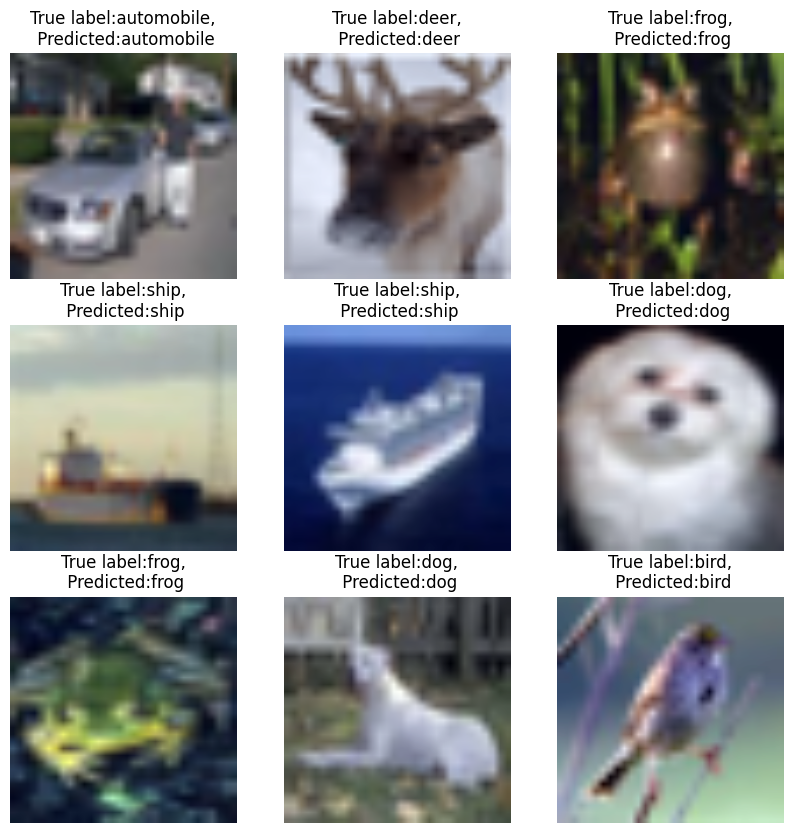

In [32]:
#创建图像标签列表 
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog', 
                 6:'frog',7:'horse',8:'ship',9:'truck'} 
 
cifar_ds = get_data('./data/10-verify-bin') 
df_test = process_dataset(cifar_ds,batch_size=1,status='test') 
def normalization(data): 
    _range = np.max(data) - np.min(data) 
    return (data - np.min(data)) / _range 
 
# 设置图像大小 
plt.figure(figsize=(10,10)) 
i = 1 
# 打印9张子图 
for dic in df_test: 
    # 预测单张图片 
    input_img = dic[0]     
    output = model.predict(Tensor(input_img)) 
    output = nn.Softmax()(output) 
    # 反馈可能性最大的类别 
    predicted = np.argmax(output.asnumpy(),axis=1)[0] 
     
    # 可视化 
    plt.subplot(3,3,i) 
    # 删除batch维度 
    input_image = np.squeeze(input_img.asnumpy(),axis=0).transpose(1,2,0) 
    # 重新归一化，方便可视化 
    input_image = normalization(input_image) 
    plt.imshow(input_image) 
    plt.xticks([]) 
    plt.yticks([]) 
    plt.axis('off') 
    plt.title('True label:%s,\n Predicted:%s'%(category_dict[dic[1].asnumpy().sum()],category_dict[predicted])) 
    i +=1 
    if i > 9 : 
        break 
 
plt.show()